# Modification of Mumby et al. (2007) to include CCA growth

In [2]:
# Load in the base packages
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
import pandas as pd
# from scipy import stats
# from scipy.optimize import curve_fit
# from scipy.integrate import odeintv
# from scipy.integrate import solve_ivp
from mpl_toolkits.mplot3d import Axes3D
from multiprocessing import Pool

# CCA model with RK4

In [3]:
# Differential equation which will take the initial population sizes of the three organisms and a dictionary including model parameters
def dNdt(C,M,A,P):
    
    dt = P['dt']
    NUMYEARS = P['NUMYEARS']
    r = P['r']
    a = P['a']
    mu = P['mu']
    gamma = P['gamma']
    g0 = P['g0']
    g1 = P['g1']
    rA = P['rA']
    algalCCA = P['algalCCA']
    coralCCA = P['coralCCA']
    f=P['f']
    kappa=P['kappa']
    phi=P['phi']
    
    # Calculating base larvae looking to settle
    Fr = (1-C-M-A)
    beta = f*C*A #Base amount of swimming larvae cued to settle
    pA = (1+kappa)/((1 + kappa)+(1-kappa))
    pF = (1-kappa)/((1 + kappa)+(1-kappa))
    gM = (g0 + (g1 - g0)*(C**0.5))*M
    # gM = g0*M
    
    #! Calculate the derivative    
    dC = r*C*Fr - a*C*M - mu*C + coralCCA*C*A + beta*phi*(pA*A + pF*Fr) #Coral equation with CCA recruitment and overgrowth incorporated
    dM = gamma*M*Fr + a*C*M - gM + algalCCA*A*M #Macroalgae equation with CCA overgrowth incorporated
    dA = rA*A*Fr - coralCCA*C*A - algalCCA*A*M - beta*phi*pA*A # AA equation 

    # dC = r*C*Fr - a*C*M - mu*C #Coral equation with CCA recruitment and overgrowth incorporated
    # dM = gamma*M*Fr + a*C*M - gM #Macroalgae equation with CCA overgrowth incorporated

    return dC, dM, dA
    # return dC, dM

def RK4(C, M, A, P): #4th-order Runge-Kutta
    # Initial values
    C_init = C
    M_init = M
    A_init = A

    # Step 1
    k1_C, k1_M, k1_A = dNdt(C, M, A, P)

    # Step 2
    C1 = C + 0.5 * k1_C
    M1 = M + 0.5 * k1_M
    A1 = A + 0.5 * k1_A
    k2_C, k2_M, k2_A = dNdt(C1, M1, A1, P)

    # Step 3
    C2 = C + 0.5 * k2_C
    M2 = M + 0.5 * k2_M
    A2 = A + 0.5 * k2_A
    k3_C, k3_M, k3_A = dNdt(C2, M2, A2, P)

    # Step 4
    C3 = C + k3_C
    M3 = M + k3_M
    A3 = A + k3_A
    k4_C, k4_M, k4_A = dNdt(C3, M3, A3, P)

    # Calculate weighted average
    dC = (k1_C + 2 * k2_C + 2 * k3_C + k4_C) / 6
    dM = (k1_M + 2 * k2_M + 2 * k3_M + k4_M) / 6
    dA = (k1_A + 2 * k2_A + 2 * k3_A + k4_A) / 6

    # Update values
    C = C_init + dC
    M = M_init + dM
    A = A_init + dA

    return C, M, A


def run_model(INIT_C, INIT_M, INIT_A, P):
   
    NUMYEARS = P['NUMYEARS']
    
    C = np.zeros((NUMYEARS+1))
    M = np.zeros((NUMYEARS+1))
    A = np.zeros((NUMYEARS+1))
    
    C[0] = INIT_C
    M[0] = INIT_M
    A[0] = INIT_A
    
    for year in np.arange(0,NUMYEARS):
        C[year+1],M[year+1],A[year+1] = RK4(C[year],M[year],A[year],P)
        # if (M[year+1] > 0.3): 
        #     # M[year+1] = M[year+1] - M[year+1]*0.03
        #     C[year+1] = C[year+1] + (1 - C[year+1]- M[year+1]- A[year+1])*0.005
        #     # A[year+1] = A[year+1] + (1 - C[year+1] - M[year+1]- A[year+1])*0.03
    
    return C, M, A

### Testing modified Lisa code with dictionary


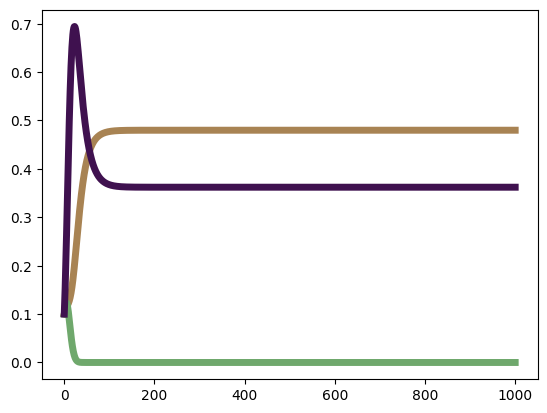

In [117]:
dt = 1 # time step (year)
NUMSTEPS = 1000
NUMYEARS = int(NUMSTEPS/dt)

r = 0.2 #coral growth rate
rA = 0.4 #CCA growth rate
gamma = 0.7 #algal growth rate

#overgrowth rates
a = 0.3 #algal overgrowth onto corals
algalCCA = 0.3 #algal overgrowth onto CCA
coralCCA = 0.1 #coral overgrowth onto CCA

#death, grazing
mu = 0.08 #coral background mortality
g0 = 0.2
g1 = 1 #maximum grazing rate

#settlement 
f = 0.1 #fecundity
phi = 1
kappa = 0.75 #Value used to scale settlement to increased settlement present on free space rather than cca tissue. Approximated from R-R Williams et al. (2010)

parameters_dict = {'dt':dt,
                    'NUMYEARS': NUMYEARS, 
                    'r': r, 
                    'a': a,
                    'mu': mu,
                    'gamma': gamma,
                    'g0': g0,
                    'g1': g1,
                    'rA': rA,
                    'algalCCA': algalCCA,
                    'coralCCA': coralCCA,
                    'f': f,
                    'kappa': kappa,
                    'phi': phi
                    }


C0 = 0.1
A0 = 0.1
M0 = 0.1

C_array, M_array, A_array = run_model(C0,M0,A0, parameters_dict)
# C_array, M_array = run_model(C0,M0, parameters_dict)

plt.plot(C_array, c='#A88353', linewidth = 5)
plt.plot(M_array, c='#6FA86C', linewidth = 5)
plt.plot(A_array, c='#3F114F', linewidth = 5)

# plt.legend(['coral', 'algae', 'CCA'], bbox_to_anchor=(1,0.5))
# plt.title('Coral repopulate a macroalgal reef through cca settlement induction');

(-0.02, 1)

/Users/zacharyquinlan/Library/Python/3.7/lib/python/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


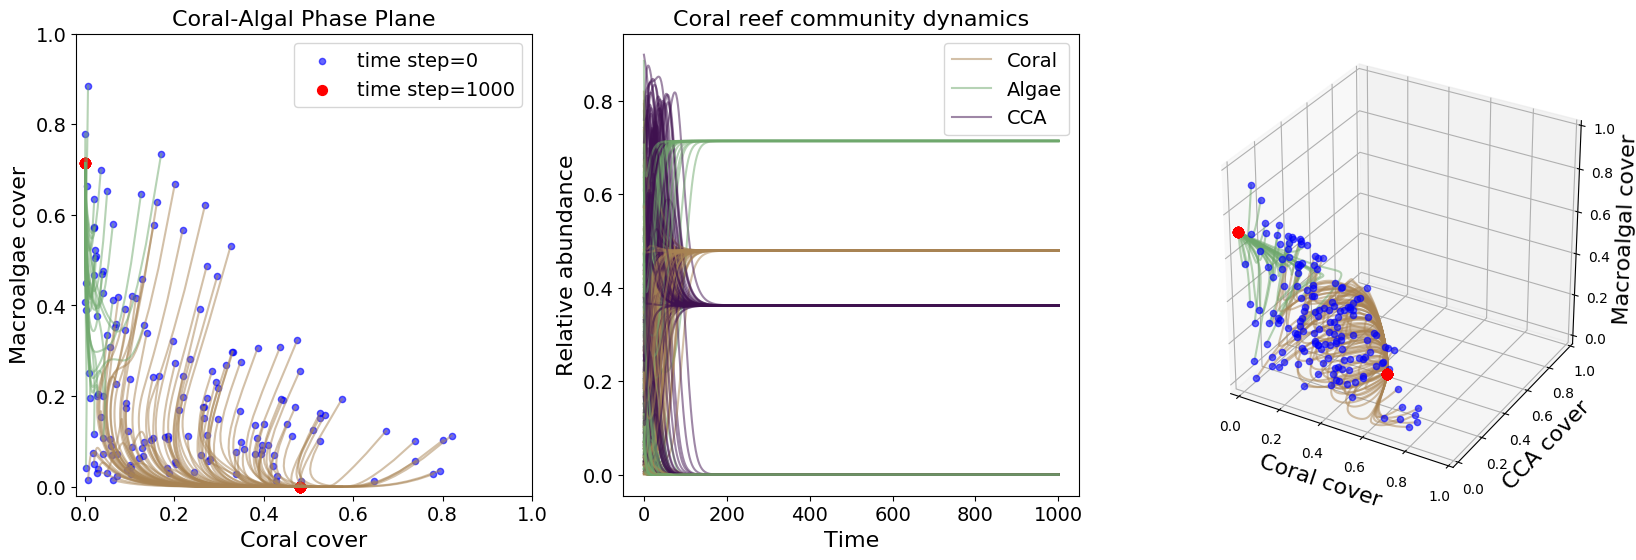

In [118]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20,6))
ax3.axis('off')
ax3 = fig.add_subplot(1,3,3, projection = '3d')

for i in np.arange(0,1000):
    C0 = np.random.random()
    M0 = np.random.random()
    CC0 = np.random.random()
    # only use initial conditions that make sense, i.e. Initial Coral + Macroalgae must be less than 1
    if (C0 + M0 + CC0 <= 1) : 
        C_array, M_array, A_array = run_model(C0,M0,CC0, parameters_dict)
        if (C_array[-1] > M_array[-1]) & (C_array[-1] > A_array[-1]): # if final coral value > final macroalgae value and > CCA value
            color = '#A88353'
        elif (A_array[-1] > M_array[-1]) & (A_array[-1] > C_array[-1]): # if final CCA value > final macroalgae value and > coral value
            color = '#3F114F'
        elif (A_array[-1] < M_array[-1]) & (M_array[-1] > C_array[-1]): # if final macroalgae value > final CCA value and > coral value
            color = '#6FA86C'
        else:
            color='grey'
        ax1.plot(C_array, M_array, color=color, alpha=0.5) # plot the trajectory in the phase plane (plot A)
        item1 = ax1.scatter(C_array[0], M_array[0], color='blue', s=20, alpha=0.6) # plot the starting point in blue
        item2 = ax1.scatter(C_array[-1], M_array[-1], color='red', s=50) # plot the final point in red
        ax2.plot(C_array, c='#A88353', alpha=0.5) # plot the coral time series in plot B
        ax2.plot(M_array, c='#6FA86C', alpha=0.5) # plot the macroalgae time series in plot B
        ax2.plot(A_array, c= '#3F114F', alpha = 0.5)
        ax3.plot(C_array, A_array, M_array, color = color, alpha = 0.5)
        item3 = ax3.scatter(C_array[0], A_array[0], M_array[0], color='blue', s=20, alpha=0.6) # plot the starting point in blue
        item4 = ax3.scatter(C_array[-1], A_array[-1],  M_array[-1],  color='red', s=50) # plot the final point in red
        

ax1.legend([item1, item2], ['time step=0', 'time step=1000'], fontsize=14)
ax1.set_xlabel("Coral cover", fontsize=16);
ax1.set_ylabel("Macroalgae cover", fontsize=16);
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax1.set_title('Coral-Algal Phase Plane', fontsize=16)
ax1.set_xlim([-0.02,1])
ax1.set_ylim([-0.02,1])

ax2.legend(['Coral', 'Algae', 'CCA'],  fontsize=14)
ax2.tick_params(axis='x', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)
ax2.set_xlabel("Time", fontsize=16);
ax2.set_ylabel("Relative abundance", fontsize=16);
ax2.set_title('Coral reef community dynamics', fontsize=16)


ax3.set_xlabel("Coral cover", fontsize=16);
ax3.set_ylabel("CCA cover", fontsize=16);
ax3.set_zlabel("Macroalgal cover", fontsize=16);
ax3.set_xlim([-0.02,1])
ax3.set_ylim([-0.02,1])
ax3.set_zlim([-0.02,1])


# 3DPlots

(-0.02, 1)

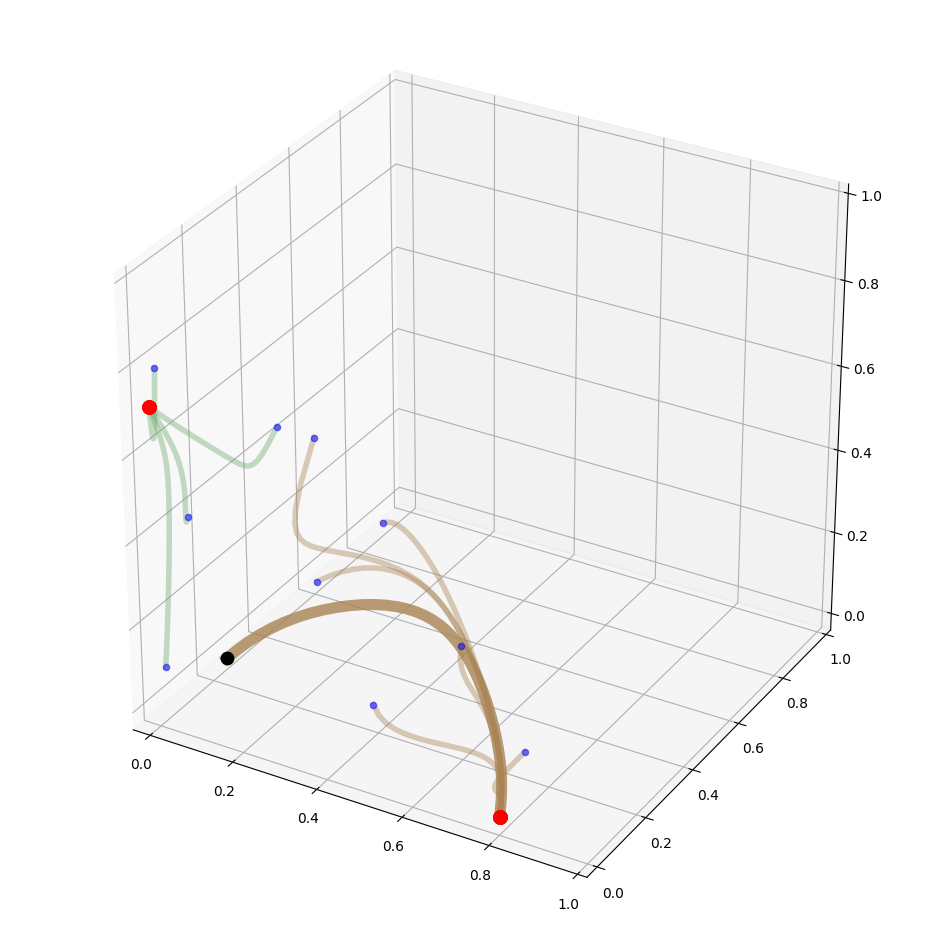

In [86]:
fig, (ax3) = plt.subplots(figsize=(12,12))
ax3.axis('off')
ax3 = fig.add_subplot(1,1,1, projection = '3d')

fig2Dictionary = {'c': [0.05, 0.1, 0.45, 0.8, 0.45, 0.01, 0.1, 0.05, 0.1, 0.01, 0.01], 'm': [0.45, 0.1, 0.1, 0.1, 0.05, 0.45, 0.1, 0.05, 0.45, 0.1, 0.8], 'a': [0.05, 0.1, 0.1, 0.1, 0.45, 0.45, 0.45, 0.8, 0.45, 0.01, 0.01]}
fig2 = pd.DataFrame(fig2Dictionary)
# for c in [0.01, 0.05, 0.1, 0.45, 0.8]:
#     for m in [0.01, 0.05, 0.1, 0.45, 0.8]:
#         for a in [0.01, 0.05, 0.1, 0.45, 0.8]:
for index, row in fig2.iterrows():
    C0 = row['c']
    M0 = row['m']
    CC0 = row['a']
# for i in np.arange(0,500):
#     C0 = np.random.random()
#     M0 = np.random.random()
#     CC0 = np.random.random()
    # only use initial conditions that make sense, i.e. Initial Coral + Macroalgae must be less than 1
    if (C0 + M0 + CC0 <= 1) : 
        C_array, M_array, A_array = run_model(C0,M0,CC0, parameters_dict)
        if (C_array[-1] > M_array[-1]) & (C_array[-1] > A_array[-1]): # if final coral value > final macroalgae value and > CCA value
            color = '#A88353'
        elif (A_array[-1] > M_array[-1]) & (A_array[-1] > C_array[-1]): # if final CCA value > final macroalgae value and > coral value
            color = '#3F114F'
        elif (A_array[-1] < M_array[-1]) & (M_array[-1] > C_array[-1]): # if final macroalgae value > final CCA value and > coral value
            color = '#6FA86C'
        else:
            color='grey'
    
        
        if C0 == 0.1 and M0 == 0.1 and CC0 == 0.1:
            ax3.plot(C_array, A_array, M_array, color = color, alpha = 0.8, linewidth = 8)
            item3 = ax3.scatter(C_array[0], A_array[0], M_array[0], color='black', s=80, alpha=1) # plot the starting point in blue

        elif C0 == 0.1 and M0 == 0.8 and CC0 == 0.1:
            ax3.plot(C_array, A_array, M_array, color = color, alpha = 0.8, linewidth = 8)
            item3 = ax3.scatter(C_array[0], A_array[0], M_array[0], color='black', s=80, alpha=1) # plot the starting point in blue

        else:
            ax3.plot(C_array, A_array, M_array, color = color, alpha = 0.4, linewidth = 4)
            item3 = ax3.scatter(C_array[0], A_array[0], M_array[0], color='blue', s=20, alpha=0.5) # plot the starting point in blue

        
        item4 = ax3.scatter(C_array[-1], A_array[-1],  M_array[-1],  color='red', s=90) # plot the final point in red


# ax3.set_xlabel("Coral cover", fontsize=15);
# ax3.set_ylabel("CCA cover", fontsize=15);
# ax3.set_zlabel("Macroalgal cover", fontsize=15);
ax3.set_xlabel("", fontsize=1);
ax3.set_ylabel("", fontsize=1);
ax3.set_zlabel("", fontsize=1);
ax3.set_xlim([-0.02,1])
ax3.set_ylim([-0.02,1])
ax3.set_zlim([-0.02,1])


# Different Additions

(-0.02, 1)

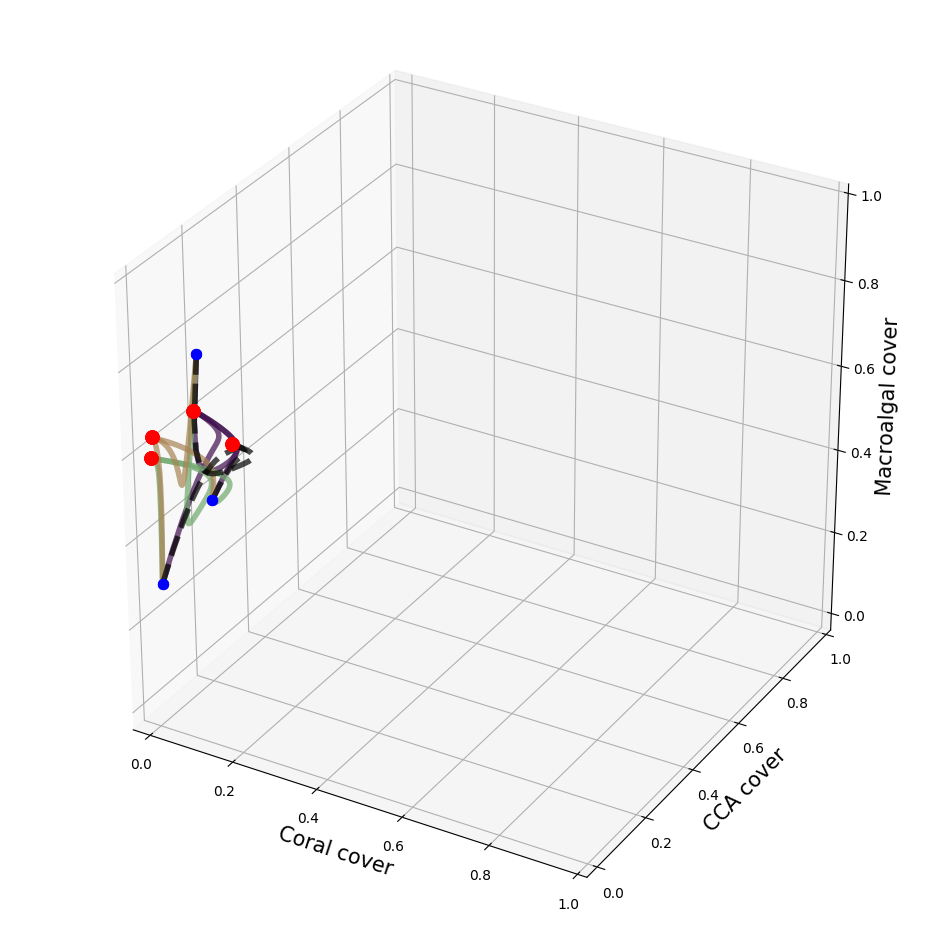

In [119]:
def run_baseModel(INIT_C, INIT_M, INIT_A, addition, P):
   
    NUMYEARS = P['NUMYEARS']
    
    C = np.zeros((NUMYEARS+1))
    M = np.zeros((NUMYEARS+1))
    A = np.zeros((NUMYEARS+1))
    
    C[0] = INIT_C
    M[0] = INIT_M
    A[0] = INIT_A
    
    
    for year in np.arange(0,NUMYEARS):
            C[year+1],M[year+1],A[year+1] = RK4(C[year],M[year],A[year],P)
    
    return C, M, A

def run_macroMinus(INIT_C, INIT_M, INIT_A, addition, P):
   
    NUMYEARS = P['NUMYEARS']
    
    C = np.zeros((NUMYEARS+1))
    M = np.zeros((NUMYEARS+1))
    A = np.zeros((NUMYEARS+1))
    
    C[0] = INIT_C
    M[0] = INIT_M
    A[0] = INIT_A
    
    
    for year in np.arange(0,NUMYEARS):
            C[year+1],M[year+1],A[year+1] = RK4(C[year],M[year],A[year],P)

            if (M[year+1] >=0.25):
                M[year+1] = M[year+1] - M[year+1]*additions
    
    return C, M, A

def run_yearlyCCA(INIT_C, INIT_M, INIT_A, addition, P):
   
    NUMYEARS = P['NUMYEARS']
    
    C = np.zeros((NUMYEARS+1))
    M = np.zeros((NUMYEARS+1))
    A = np.zeros((NUMYEARS+1))
    
    C[0] = INIT_C
    M[0] = INIT_M
    A[0] = INIT_A
    
    
    for year in np.arange(0,NUMYEARS):
            C[year+1],M[year+1],A[year+1] = RK4(C[year],M[year],A[year],P)

            if (M[year+1] >=0.25):
                A[year+1] = A[year+1] + (1 - C[year+1]- M[year+1]- A[year+1])*additions
    
    return C, M, A

def run_yearlyCCACoral(INIT_C, INIT_M, INIT_A, addition, P):
   
    NUMYEARS = P['NUMYEARS']
    
    C = np.zeros((NUMYEARS+1))
    M = np.zeros((NUMYEARS+1))
    A = np.zeros((NUMYEARS+1))
    
    C[0] = INIT_C
    M[0] = INIT_M
    A[0] = INIT_A
    
    
    for year in np.arange(0,NUMYEARS):
            C[year+1],M[year+1],A[year+1] = RK4(C[year],M[year],A[year],P)

            if (M[year+1] >=0.25):
                C[year+1] = C[year+1] + (1 - C[year+1]- M[year+1]- A[year+1])*0.002
                A[year+1] = A[year+1] + (1 - C[year+1]- M[year+1]- A[year+1])*additions
    
    return C, M, A

def run_yearlyMacroCoral(INIT_C, INIT_M, INIT_A, addition, P):
   
    NUMYEARS = P['NUMYEARS']
    
    C = np.zeros((NUMYEARS+1))
    M = np.zeros((NUMYEARS+1))
    A = np.zeros((NUMYEARS+1))
    
    C[0] = INIT_C
    M[0] = INIT_M
    A[0] = INIT_A
    
    
    for year in np.arange(0,NUMYEARS):
            C[year+1],M[year+1],A[year+1] = RK4(C[year],M[year],A[year],P)

            if (M[year+1] >=0.25):
                C[year+1] = C[year+1] + (1 - C[year+1]- M[year+1]- A[year+1])*0.002
                M[year+1] = M[year+1] - M[year+1]*additions
                # A[year+1] = A[year+1] + (1 - C[year+1]- M[year+1]- A[year+1])*additions
    
    return C, M, A

def run_yearlyCoral(INIT_C, INIT_M, INIT_A, addition, P):
   
    NUMYEARS = P['NUMYEARS']
    
    C = np.zeros((NUMYEARS+1))
    M = np.zeros((NUMYEARS+1))
    A = np.zeros((NUMYEARS+1))
    
    C[0] = INIT_C
    M[0] = INIT_M
    A[0] = INIT_A
    
    
    for year in np.arange(0,NUMYEARS):
            C[year+1],M[year+1],A[year+1] = RK4(C[year],M[year],A[year],P)

            if (M[year+1] >=0.25):
                C[year+1] = C[year+1] + (1 - C[year+1]- M[year+1]- A[year+1])*0.002
    
    return C, M, A

pointsDictionary = {'c': [0.01, 0.01, 0.05], 'm': [0.3, 0.4, 0.8], 'a': [0.01, 0.2, 0.1]}

startPoints = pd.DataFrame(pointsDictionary)

fig, (ax3) = plt.subplots(figsize=(12,12))
ax3.axis('off')
ax3 = fig.add_subplot(1,1,1, projection = '3d')

additions = 0.065


for model in ['yearlyAdditions', 'macroMinus', 'run_yearlyCoral', 'yearlyCCACoral']:
    for index, row in startPoints.iterrows():
        C0 = row['c']
        M0 = row['m']
        CC0 = row['a']
             
  
        if model == 'yearlyAdditions':
            C_array, M_array, A_array = run_yearlyCCA(C0, M0 , CC0, additions, parameters_dict)
            line = 'solid'
            color = '#3F114F'

        if model == 'macroMinus':
            C_array, M_array, A_array = run_macroMinus(C0,M0,CC0, additions, parameters_dict)
            line = 'solid'
            color = '#6FA86C'

        if model == 'run_yearlyCoral':
            C_array, M_array, A_array = run_yearlyCoral(C0,M0,CC0, additions, parameters_dict)
            line = 'solid'
            color = '#A88353'

        if model == 'yearlyCCACoral':
            C_array, M_array, A_array = run_yearlyCCACoral(C0,M0,CC0, additions, parameters_dict)
            line = 'dashed'
            color = 'black'
        
        # if (C_array[-1] > M_array[-1]) & (C_array[-1] > A_array[-1]): # if final coral value > final macroalgae value and > CCA value
        #     color = '#A88353'
        # elif (A_array[-1] > M_array[-1]) & (A_array[-1] > C_array[-1]): # if final CCA value > final macroalgae value and > coral value
        #     color = '#3F114F'
        # elif (A_array[-1] < M_array[-1]) & (M_array[-1] > C_array[-1]): # if final macroalgae value > final CCA value and > coral value
        #     color = '#6FA86C'
        # else:
        #     color='grey'


        ax3.plot(C_array, A_array, M_array, linestyle = line, color = color, alpha = 0.7, linewidth = 4)


        item3 = ax3.scatter(C_array[0], A_array[0], M_array[0], color='blue', s=50, alpha=0.7) # plot the starting point in blue
        item4 = ax3.scatter(C_array[-1], A_array[-1],  M_array[-1],  color='red', s=90) # plot the final point in red


ax3.set_xlabel("Coral cover", fontsize=15);
ax3.set_ylabel("CCA cover", fontsize=15);
ax3.set_zlabel("Macroalgal cover", fontsize=15);
ax3.set_xlim([-0.02,1])
ax3.set_ylim([-0.02,1])
ax3.set_zlim([-0.02,1])


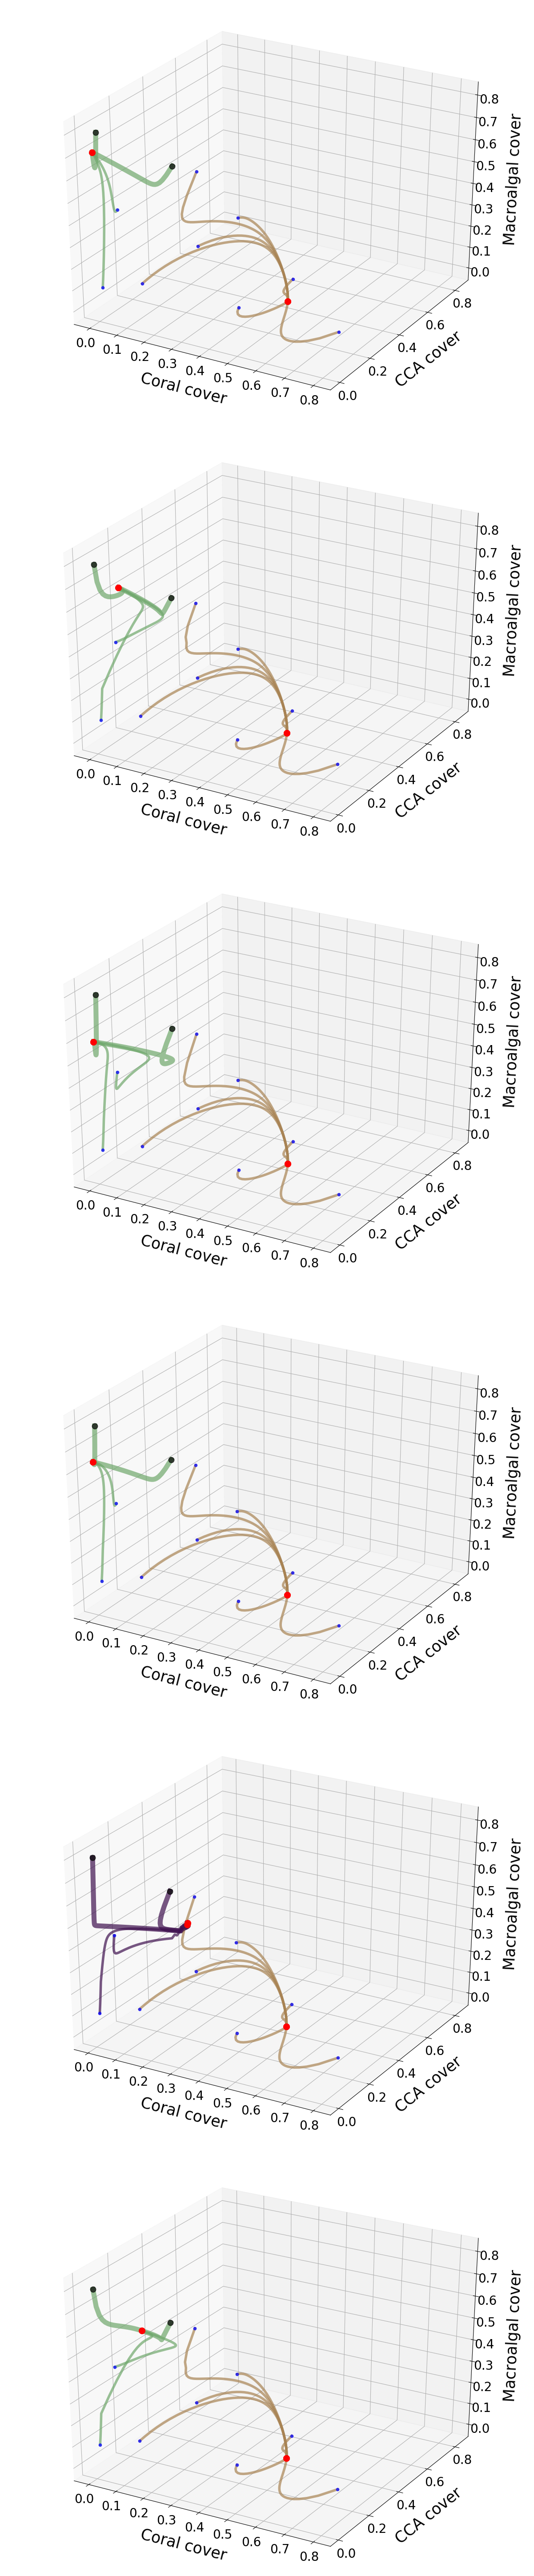

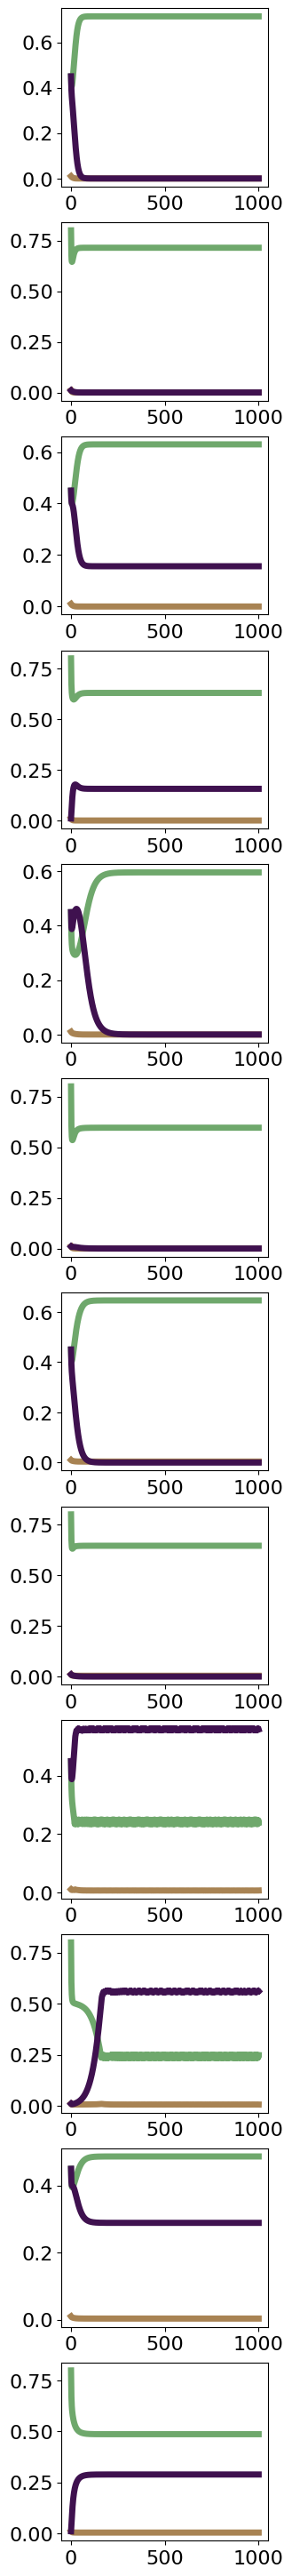

In [120]:
fig, axs = plt.subplots(6,1, figsize=(15.25, 75),subplot_kw={'projection': '3d'})
fig.subplots_adjust(wspace=0, hspace=0.05)
# fig, axs = plt.subplots(6,1, figsize=(25, 75))
axs_flat = axs.flatten()

figPlot2, axs2= plt.subplots(12, 1, figsize=(3, 37))
axs_flat2 = axs2.flatten()


lineIndex = 0


for index, model in enumerate(['baseModel', 'yearlyAdditions', 'macroMinus', 'run_yearlyCoral', 'yearlyMacroCoral', 'yearlyCCACoral']):
    axs_flat[index].yaxis.set_tick_params(labelsize = 20)
    axs_flat[index].xaxis.set_tick_params(labelsize = 20)
    axs_flat[index].zaxis.set_tick_params(labelsize = 20)

    axs_flat[index].set_xlabel("Coral cover", fontsize=25, labelpad = 20);
    axs_flat[index].set_ylabel("CCA cover", fontsize=25, labelpad = 20);
    axs_flat[index].set_zlabel("Macroalgal cover", fontsize=25, labelpad = 20);



    for i, row in fig2.iterrows():
        C0 = row['c']
        M0 = row['m']
        CC0 = row['a']

        if model == 'baseModel':
            C_array, M_array, A_array = run_baseModel(C0, M0 , CC0, additions, parameters_dict)          
    
        if model == 'yearlyAdditions':
            C_array, M_array, A_array = run_yearlyCCA(C0, M0 , CC0, additions, parameters_dict)
            # line = 'solid'
            # color = '#3F114F'
    
        if model == 'yearlyMacroCoral':
            C_array, M_array, A_array = run_yearlyMacroCoral(C0, M0 , CC0, additions, parameters_dict)
    
        if model == 'macroMinus':
            C_array, M_array, A_array = run_macroMinus(C0,M0,CC0, additions, parameters_dict)
            # line = 'solid'
            # color = '|#6FA86C'
    
        if model == 'run_yearlyCoral':
            C_array, M_array, A_array = run_yearlyCoral(C0,M0,CC0, additions, parameters_dict)
            # line = 'solid'
            # color = '#A88353'
    
        if model == 'yearlyCCACoral':
            C_array, M_array, A_array = run_yearlyCCACoral(C0,M0,CC0, additions, parameters_dict)
            # line = 'dashed'
            # color = 'black'

        if (C_array[-1] > M_array[-1]) & (C_array[-1] > A_array[-1]): # if final coral value > final macroalgae value and > CCA value
            color = '#A88353'
        elif (A_array[-1] > M_array[-1]) & (A_array[-1] > C_array[-1]): # if final CCA value > final macroalgae value and > coral value
            color = '#3F114F'
        elif (A_array[-1] < M_array[-1]) & (M_array[-1] > C_array[-1]): # if final macroalgae value > final CCA value and > coral value
            color = '#6FA86C'
        else:
            color='grey'




        # Plotting the 3D plots making sure to highlight the scenarios which are used to plot the time series
        if C0 == 0.01 and M0 == 0.45 and CC0 == 0.45:
            axs_flat[index].plot(C_array, A_array, M_array, color = color, alpha = 0.7, linewidth = 8)
            item3 = axs_flat[index].scatter(C_array[0], A_array[0], M_array[0], color='black', s=80, alpha=0.7) # plot the starting point in blue

            axs_flat2[lineIndex].plot(C_array, c='#A88353', linewidth = 5)
            axs_flat2[lineIndex].plot(M_array, c='#6FA86C', linewidth = 5)
            axs_flat2[lineIndex].plot(A_array, c='#3F114F', linewidth = 5)
            axs_flat2[lineIndex].xaxis.set_tick_params(labelsize =16)
            axs_flat2[lineIndex].yaxis.set_tick_params(labelsize =16)

            lineIndex = lineIndex + 1
        

        elif C0 == 0.01 and M0 == 0.8 and CC0 == 0.01:

            axs_flat[index].plot(C_array, A_array, M_array, color = color, alpha = 0.7, linewidth = 8)
            item3 = axs_flat[index].scatter(C_array[0], A_array[0], M_array[0], color='black', s=80, alpha=0.7) # plot the starting point in blue

            axs_flat2[lineIndex].plot(C_array, c='#A88353', linewidth = 5)
            axs_flat2[lineIndex].plot(M_array, c='#6FA86C', linewidth = 5)
            axs_flat2[lineIndex].plot(A_array, c='#3F114F', linewidth = 5)
            axs_flat2[lineIndex].xaxis.set_tick_params(labelsize =16)
            axs_flat2[lineIndex].yaxis.set_tick_params(labelsize =16)

        
            lineIndex = lineIndex + 1



        else:
            axs_flat[index].plot(C_array, A_array, M_array, color = color, alpha = 0.7, linewidth = 4)
            item3 = axs_flat[index].scatter(C_array[0], A_array[0], M_array[0], color='blue', s=20, alpha=0.7) # plot the starting point in blue


        

        
        item4 = axs_flat[index].scatter(C_array[-1], A_array[-1],  M_array[-1],  color='red', s=90) # plot the final point in red

        


# ax3.set_xlabel("Coral cover", fontsize=15);
# ax3.set_ylabel("CCA cover", fontsize=15);
# ax3.set_zlabel("Macroalgal cover", fontsize=15);
# ax3.set_xlim([-0.02,1])
# ax3.set_ylim([-0.02,1])
# ax3.set_zlim([-0.02,1])
